<a href="https://colab.research.google.com/github/IT24103806/AI_Sinhala_Letter_Identifier/blob/main/Sinhala_Letter_Recognation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First, let's install required packages
!pip install kaggle opendatasets --quiet

import opendatasets as od
import os
import shutil
from pathlib import Path

# Method 1: Using opendatasets (easier approach)
def download_dataset_with_kaggle_json():
    # Upload your kaggle.json file
    from google.colab import files
    print("Please upload your kaggle.json file:")
    uploaded = files.upload()

    # Create .kaggle directory and move the file
    kaggle_dir = Path.home() / '.kaggle'
    kaggle_dir.mkdir(exist_ok=True)

    # Move the uploaded file
    for filename in uploaded.keys():
        shutil.move(filename, kaggle_dir / 'kaggle.json')
        print(f"Moved {filename} to {kaggle_dir / 'kaggle.json'}")

    # Set permissions
    os.chmod(kaggle_dir / 'kaggle.json', 0o600)

    print("Kaggle authentication setup complete!")

    # Now download the dataset
    dataset_url = 'https://www.kaggle.com/datasets/sathiralamal/sinhala-letter-454'
    od.download(dataset_url)

# Run the download function
download_dataset_with_kaggle_json()

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Moved kaggle.json to /root/.kaggle/kaggle.json
Kaggle authentication setup complete!
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: it24103806peirispvtd
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sathiralamal/sinhala-letter-454


100%|██████████| 206M/206M [00:00<00:00, 939MB/s] 


In [ ]:
import kaggle
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import albumentations as A

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
# Download dataset
def download_dataset():
    try:
        kaggle.api.dataset_download_files('sathiralamal/sinhala-letter-454', path='./data', unzip=True)
        print("Dataset downloaded successfully!")
    except Exception as e:
        print(f"Error downloading dataset: {e}")

download_dataset()

# Explore dataset structure
def explore_dataset():
    data_dir = Path('./data')
    print("Dataset contents:")
    for item in data_dir.iterdir():
        print(f"  {item.name}")

    # Check for train/test directories or CSV files
    train_dir = data_dir / 'train'
    test_dir = data_dir / 'test'

    if train_dir.exists():
        print(f"\nTraining samples: {len(list(train_dir.glob('*/*')))}")
    if test_dir.exists():
        print(f"Test samples: {len(list(test_dir.glob('*/*')))}")

explore_dataset()

Dataset URL: https://www.kaggle.com/datasets/sathiralamal/sinhala-letter-454
Dataset downloaded successfully!
Dataset contents:
  Dataset454


Found 1 classes: ['Dataset454']...
Total images loaded: 0


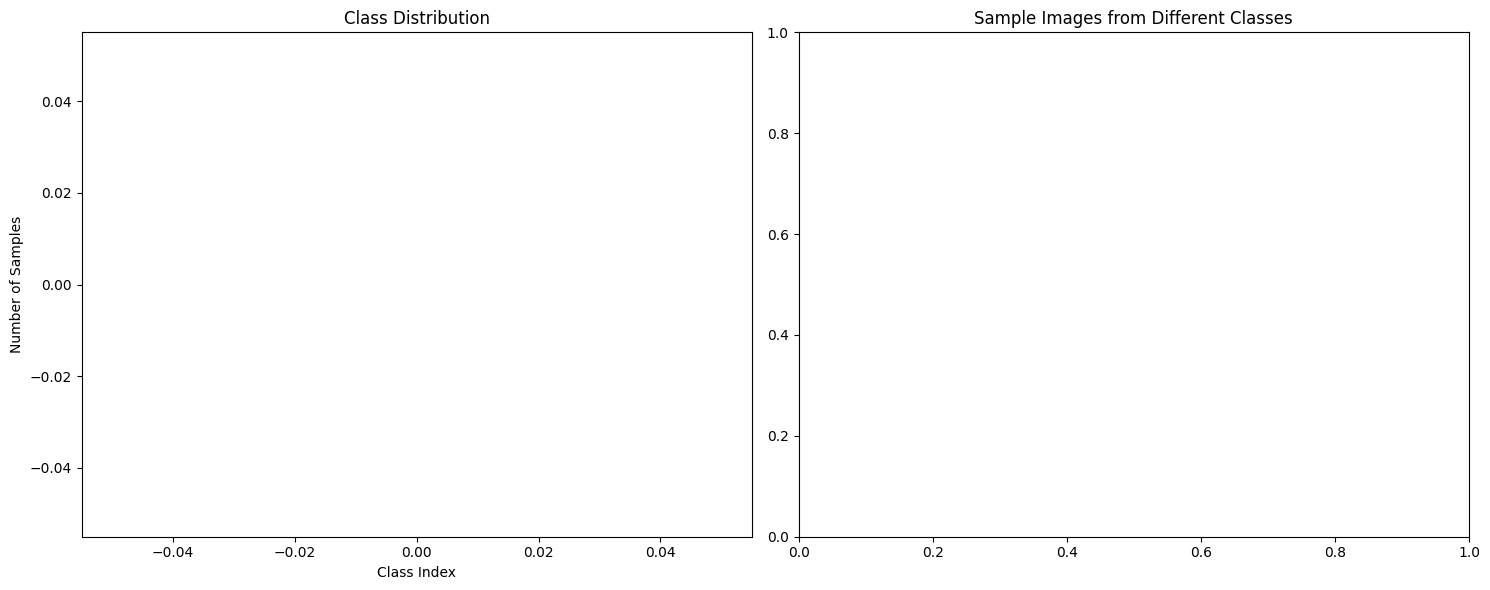

Number of classes: 1
Total samples: 0
Min samples per class: nan
Max samples per class: nan


In [ ]:
class SinhalaDataLoader:
    def __init__(self, data_path):
        self.data_path = Path(data_path)
        self.classes = []
        self.image_paths = []
        self.labels = []

    def load_data(self):
        """Load image paths and labels from directory structure"""
        # Assuming structure: data/train/class_name/*.jpg
        train_dir = self.data_path / 'train'

        if not train_dir.exists():
            # Alternative structure - adjust based on actual dataset structure
            train_dir = self.data_path

        self.classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
        print(f"Found {len(self.classes)} classes: {self.classes[:10]}...")  # Show first 10

        for class_idx, class_name in enumerate(self.classes):
            class_dir = train_dir / class_name
            if class_dir.exists():
                for img_path in class_dir.glob('*.jpg'):
                    self.image_paths.append(str(img_path))
                    self.labels.append(class_idx)

        print(f"Total images loaded: {len(self.image_paths)}")
        return self.image_paths, self.labels, self.classes

# Initialize data loader
data_loader = SinhalaDataLoader('./data')
image_paths, labels, classes = data_loader.load_data()

# Analyze class distribution
def analyze_class_distribution(labels, classes):
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    label_counts = pd.Series(labels).value_counts().sort_index()
    plt.bar(range(len(classes)), label_counts.values)
    plt.title('Class Distribution')
    plt.xlabel('Class Index')
    plt.ylabel('Number of Samples')

    plt.subplot(1, 2, 2)
    # Show sample images from different classes
    unique_labels = np.unique(labels)
    plt.title('Sample Images from Different Classes')

    for i, label in enumerate(unique_labels[:8]):  # Show first 8 classes
        idx = np.where(np.array(labels) == label)[0][0]
        img = cv2.imread(image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(f'Class: {classes[label]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Number of classes: {len(classes)}")
    print(f"Total samples: {len(labels)}")
    print(f"Min samples per class: {label_counts.min()}")
    print(f"Max samples per class: {label_counts.max()}")

analyze_class_distribution(labels, classes)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

# First, let's explore what's actually in the data directory
def explore_dataset_structure():
    data_path = Path('./data')
    print("Full dataset structure:")

    all_files = []
    for root, dirs, files in os.walk(data_path):
        level = root.replace(str(data_path), '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}📁 {os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                print(f"{subindent}📄 {file}")
                all_files.append(os.path.join(root, file))
        if len(files) > 5:
            print(f"{subindent}... and {len(files) - 5} more files")

    return all_files

# Get all image files
all_image_files = explore_dataset_structure()
print(f"\nTotal image files found: {len(all_image_files)}")

# If no images found, let's check alternative paths
if len(all_image_files) == 0:
    print("\nTrying alternative dataset locations...")
    alternative_paths = [
        './data/sinhala-letter-454',
        './data/train',
        './data/Train',
        './data/images'
    ]

    for alt_path in alternative_paths:
        if Path(alt_path).exists():
            print(f"Found alternative path: {alt_path}")
            all_image_files = list(Path(alt_path).rglob('*.jpg')) + list(Path(alt_path).rglob('*.jpeg')) + list(Path(alt_path).rglob('*.png'))
            print(f"Found {len(all_image_files)} images in {alt_path}")
            break

# Let's see a sample of the image paths
if all_image_files:
    print("\nSample image paths:")
    for i, path in enumerate(all_image_files[:5]):
        print(f"  {i+1}. {path}")

Streaming output truncated to the last 5000 lines.
        📄 44xccd.jpg
        📄 46xccd.jpg
        📄 16xccd.jpg
        📄 20xccd.jpg
        📄 81vld.jpg
        ... and 187 more files
      📁 422/
        📄 44xccd.jpg
        📄 16xccd.jpg
        📄 20xccd.jpg
        📄 81vld.jpg
        📄 156.jpg
        ... and 187 more files
      📁 58/
        📄 44xccd.jpg
        📄 46xccd.jpg
        📄 16xccd.jpg
        📄 20xccd.jpg
        📄 81vld.jpg
        ... and 187 more files
      📁 229/
        📄 44xccd.jpg
        📄 46xccd.jpg
        📄 20xccd.jpg
        📄 81vld.jpg
        📄 156.jpg
        ... and 187 more files
      📁 186/
        📄 44xccd.jpg
        📄 46xccd.jpg
        📄 16xccd.jpg
        📄 20xccd.jpg
        📄 81vld.jpg
        ... and 187 more files
      📁 29/
        📄 44xccd.jpg
        📄 46xccd.jpg
        📄 16xccd.jpg
        📄 81vld.jpg
        📄 156.jpg
        ... and 187 more files
      📁 109/
        📄 44xccd.jpg
        📄 16xccd.jpg
        📄 20xccd.jpg
        📄

In [ ]:
class RobustSinhalaDataLoader:
    def __init__(self, data_path='./data'):
        self.data_path = Path(data_path)
        self.classes = []
        self.image_paths = []
        self.labels = []

    def find_images_and_labels(self):
        """Find all images and extract labels from directory structure"""
        # Find all image files
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']

        for ext in image_extensions:
            self.image_paths.extend(self.data_path.rglob(ext))

        print(f"Found {len(self.image_paths)} images total")

        # Extract classes from directory structure
        class_set = set()
        for img_path in self.image_paths:
            # Assuming structure: .../class_name/image.jpg
            class_name = img_path.parent.name
            class_set.add(class_name)

        self.classes = sorted(list(class_set))
        print(f"Found {len(self.classes)} classes: {self.classes[:10]}...")  # Show first 10

        # Create label mapping
        class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes)}

        # Assign labels
        self.labels = []
        valid_image_paths = []

        for img_path in self.image_paths:
            class_name = img_path.parent.name
            if class_name in class_to_idx:
                self.labels.append(class_to_idx[class_name])
                valid_image_paths.append(str(img_path))

        self.image_paths = valid_image_paths

        print(f"Final dataset: {len(self.image_paths)} images, {len(self.classes)} classes")
        return self.image_paths, self.labels, self.classes

# Initialize and load data
data_loader = RobustSinhalaDataLoader()
image_paths, labels, classes = data_loader.find_images_and_labels()

# Check if we have data now
if len(image_paths) == 0:
    print("ERROR: No images found! Please check:")
    print("1. Dataset was downloaded correctly")
    print("2. The file structure")
    print("3. File permissions")
else:
    print(f"SUCCESS: Loaded {len(image_paths)} images across {len(classes)} classes")

Found 108933 images total
Found 454 classes: ['1', '10', '100', '101', '102', '103', '104', '105', '106', '107']...
Final dataset: 108933 images, 454 classes
SUCCESS: Loaded 108933 images across 454 classes


Testing image loading...
Loading: data/Dataset454/test/89/36xccd.jpg
  ✅ Success - Shape: (80, 80, 3), Label: 442
Loading: data/Dataset454/test/89/94.jpg
  ✅ Success - Shape: (80, 80, 3), Label: 442
Loading: data/Dataset454/test/89/w48.jpg
  ✅ Success - Shape: (80, 80, 3), Label: 442


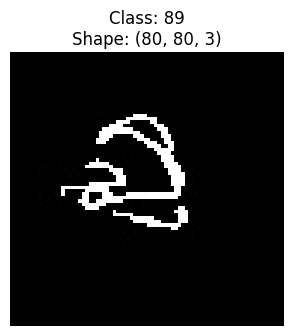

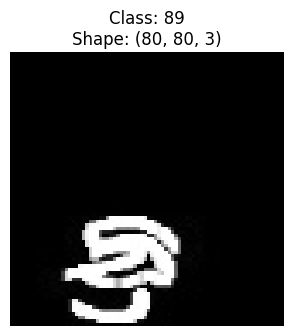

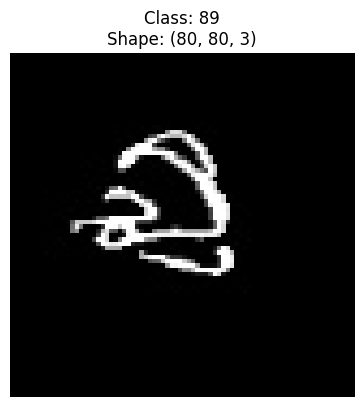


Loading test results:
  Successful: 3/3
  Failed: 0


In [ ]:
# Test if we can actually load images
def test_image_loading(image_paths, labels, num_samples=3):
    successful_loads = 0
    failed_paths = []

    print("Testing image loading...")

    for i in range(min(num_samples, len(image_paths))):
        try:
            img_path = image_paths[i]
            print(f"Loading: {img_path}")

            img = cv2.imread(img_path)
            if img is not None:
                successful_loads += 1
                print(f"  ✅ Success - Shape: {img.shape}, Label: {labels[i]}")

                # Display the image
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, i+1)
                plt.imshow(img_rgb)
                plt.title(f'Class: {classes[labels[i]]}\nShape: {img.shape}')
                plt.axis('off')

            else:
                failed_paths.append(img_path)
                print(f"  ❌ Failed to load: {img_path}")

        except Exception as e:
            failed_paths.append(img_path)
            print(f"  ❌ Error loading {img_path}: {e}")

    plt.tight_layout()
    plt.show()

    print(f"\nLoading test results:")
    print(f"  Successful: {successful_loads}/{num_samples}")
    print(f"  Failed: {len(failed_paths)}")

    return successful_loads > 0

# Run the test
if len(image_paths) > 0:
    test_success = test_image_loading(image_paths, labels)
else:
    test_success = False

In [ ]:
class FixedPreprocessingPipelines:
    def __init__(self, target_size=(64, 64)):
        self.target_size = target_size

    def basic_preprocess(self, image):
        """Basic preprocessing - resize and normalize"""
        # Handle grayscale images
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        image = cv2.resize(image, self.target_size)
        image = image.astype('float32') / 255.0
        return image

    def advanced_preprocess_v1(self, image):
        """Advanced preprocessing with noise reduction and contrast enhancement"""
        # Handle grayscale images
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Resize
        image = cv2.resize(image, self.target_size)

        # Gaussian blur for noise reduction
        image = cv2.GaussianBlur(image, (3, 3), 0)

        # CLAHE for contrast enhancement
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        lab[:,:,0] = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(lab[:,:,0])
        image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        image = image.astype('float32') / 255.0
        return image

    def advanced_preprocess_v2(self, image):
        """Edge enhancement preprocessing"""
        # Handle grayscale images
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        original_size = image.shape[:2]
        image = cv2.resize(image, self.target_size)

        # Convert to grayscale for edge detection
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Edge enhancement
        edges = cv2.Canny(gray, 50, 150)
        edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

        # Combine original with edges
        enhanced = cv2.addWeighted(image, 0.7, edges, 0.3, 0)
        enhanced = enhanced.astype('float32') / 255.0

        return enhanced

    def grayscale_preprocess(self, image):
        """Convert to grayscale and preprocess"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = cv2.resize(image, self.target_size)
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=-1)  # Add channel dimension
        return image

✅ Successfully processed sample 1
✅ Successfully processed sample 2
✅ Successfully processed sample 3


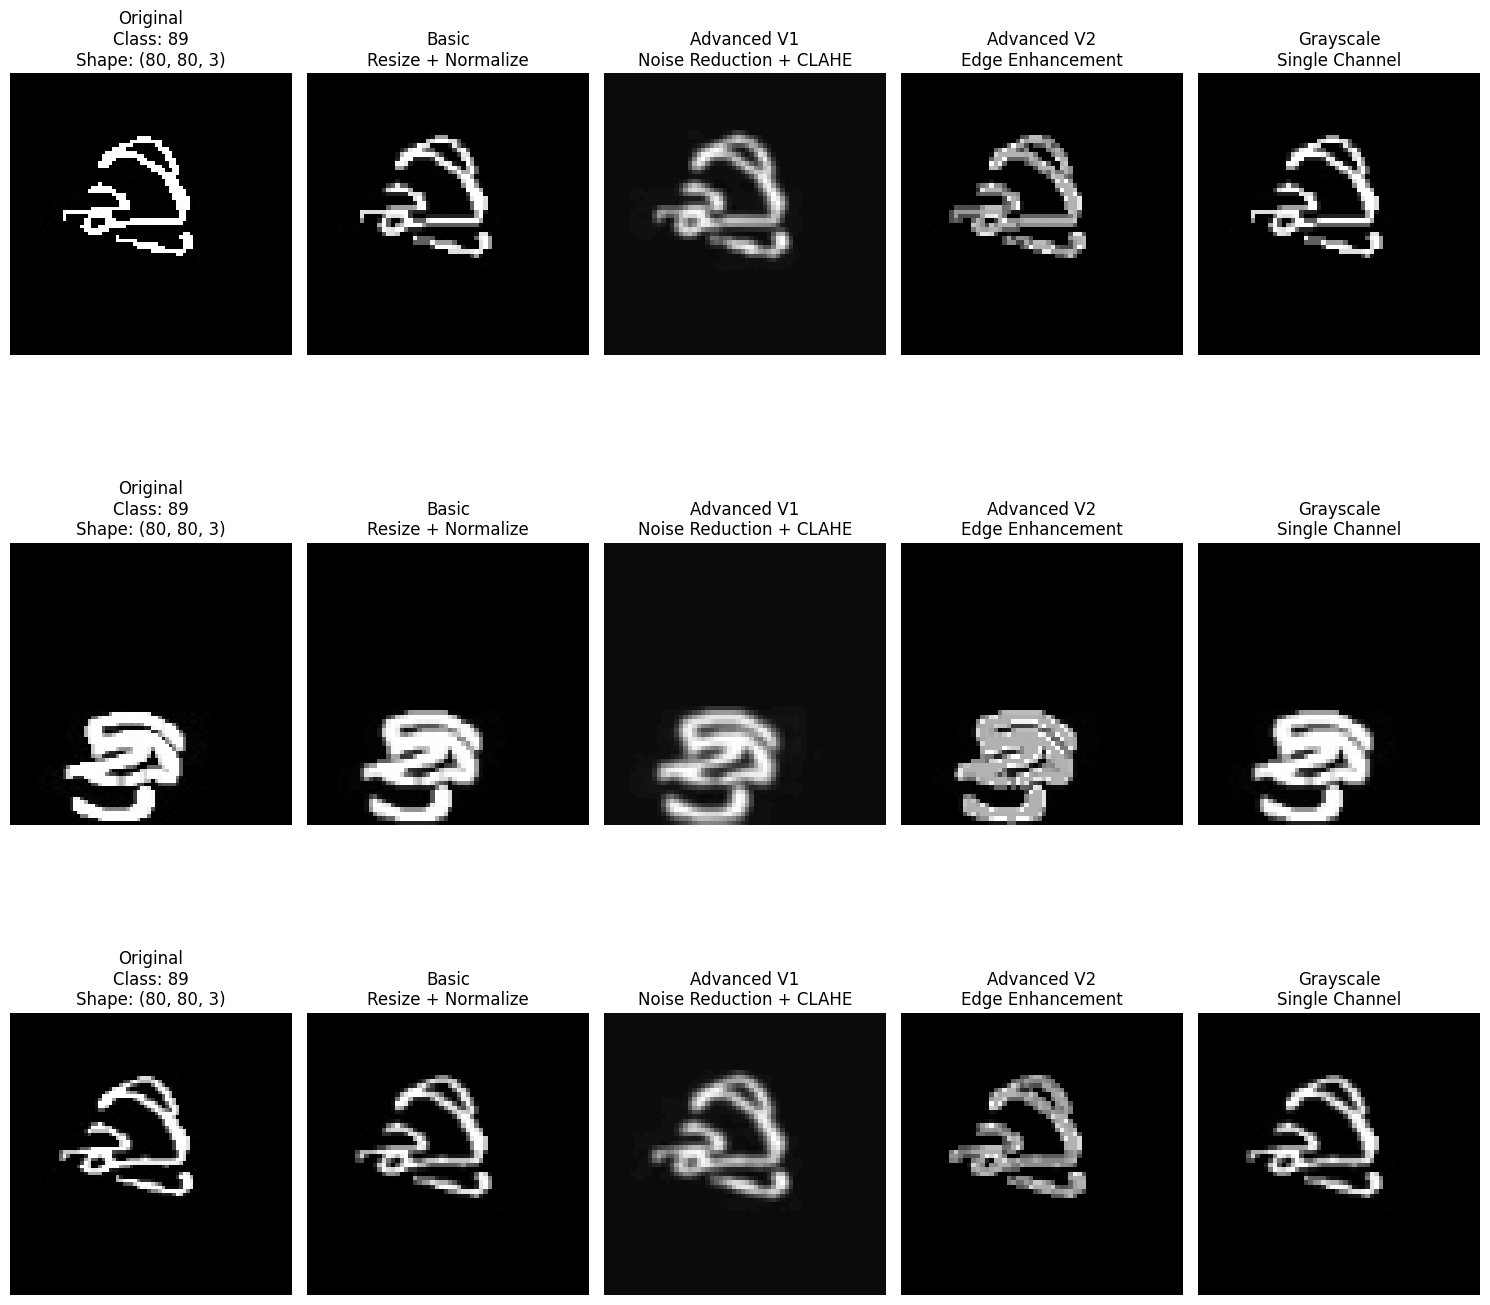


Preprocessing test completed: 3/3 successful


In [ ]:
def safe_preprocessing_test(image_paths, labels, classes, sample_size=3):
    """Test preprocessing with error handling"""
    if len(image_paths) == 0:
        print("No images to process!")
        return

    preprocessor = FixedPreprocessingPipelines()

    plt.figure(figsize=(15, 5 * sample_size))

    successful_tests = 0

    for i in range(min(sample_size, len(image_paths))):
        try:
            # Load original image
            img_path = image_paths[i]
            img_orig = cv2.imread(img_path)

            if img_orig is None:
                print(f"Failed to load image: {img_path}")
                continue

            img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

            # Apply different preprocessing
            img_basic = preprocessor.basic_preprocess(img_orig.copy())
            img_adv1 = preprocessor.advanced_preprocess_v1(img_orig.copy())
            img_adv2 = preprocessor.advanced_preprocess_v2(img_orig.copy())
            img_gray = preprocessor.grayscale_preprocess(img_orig.copy())

            # Plot original
            plt.subplot(sample_size, 5, i*5 + 1)
            plt.imshow(img_orig)
            plt.title(f'Original\nClass: {classes[labels[i]]}\nShape: {img_orig.shape}')
            plt.axis('off')

            # Plot basic
            plt.subplot(sample_size, 5, i*5 + 2)
            plt.imshow(img_basic)
            plt.title('Basic\nResize + Normalize')
            plt.axis('off')

            # Plot advanced v1
            plt.subplot(sample_size, 5, i*5 + 3)
            plt.imshow(img_adv1)
            plt.title('Advanced V1\nNoise Reduction + CLAHE')
            plt.axis('off')

            # Plot advanced v2
            plt.subplot(sample_size, 5, i*5 + 4)
            plt.imshow(img_adv2)
            plt.title('Advanced V2\nEdge Enhancement')
            plt.axis('off')

            # Plot grayscale
            plt.subplot(sample_size, 5, i*5 + 5)
            plt.imshow(img_gray.squeeze(), cmap='gray')
            plt.title('Grayscale\nSingle Channel')
            plt.axis('off')

            successful_tests += 1
            print(f"✅ Successfully processed sample {i+1}")

        except Exception as e:
            print(f"❌ Error processing sample {i+1}: {e}")
            continue

    plt.tight_layout()
    plt.show()

    print(f"\nPreprocessing test completed: {successful_tests}/{sample_size} successful")

# Run the safe test
if len(image_paths) > 0:
    safe_preprocessing_test(image_paths, labels, classes)
else:
    print("Cannot run preprocessing test - no images available!")

Starting augmentation test with 108933 available images...
Processing sample 1: 36xccd.jpg
  ✅ Successfully created 5/5 augmentations for sample 1
Processing sample 2: 94.jpg


/tmp/ipython-input-307639580.py:25: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, alpha=1, sigma=50, alpha_affine=50),  # Replaced IAAPiecewiseAffine
/tmp/ipython-input-307639580.py:34: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),


  ✅ Successfully created 5/5 augmentations for sample 2
Processing sample 3: w48.jpg
  ✅ Successfully created 5/5 augmentations for sample 3


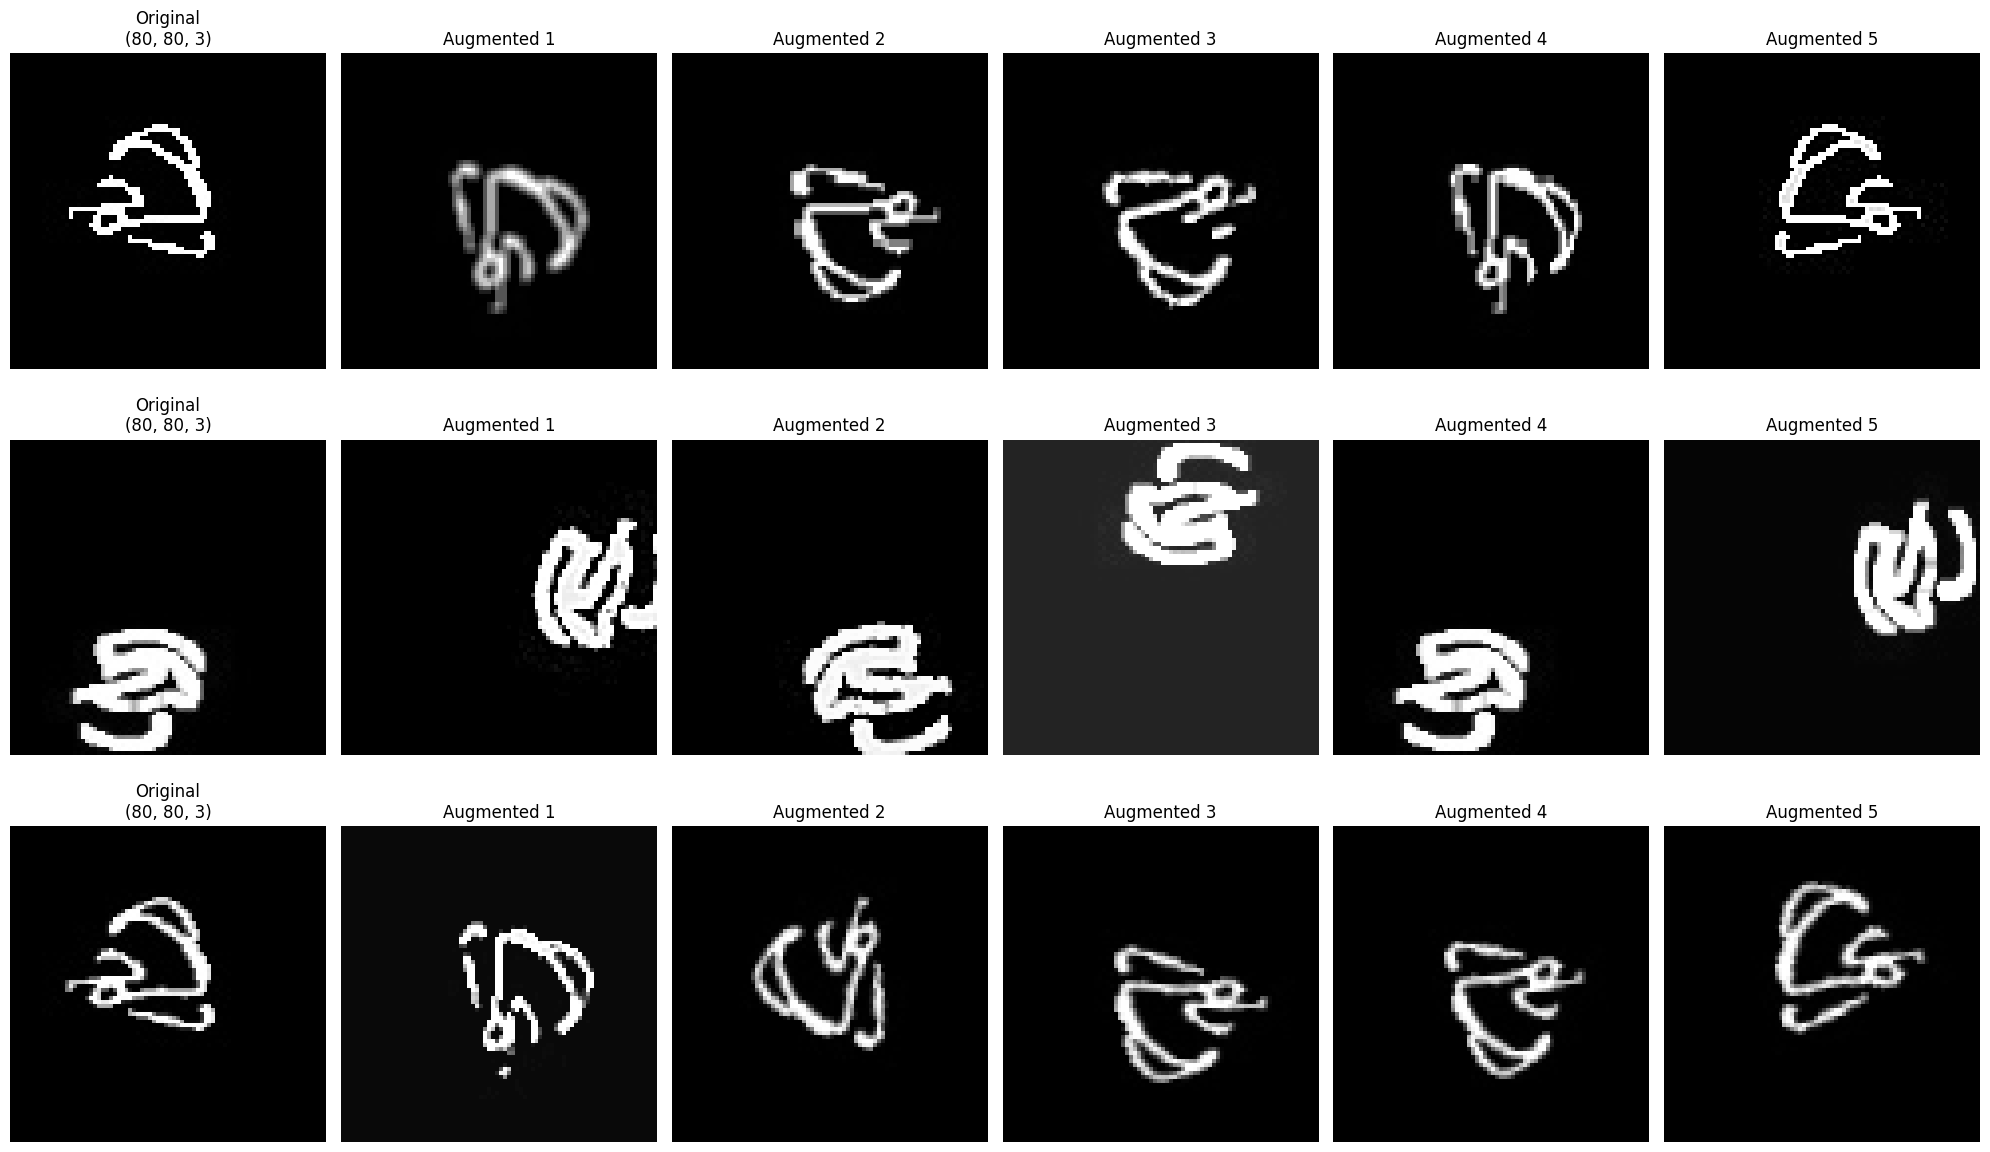


🎉 Augmentation test completed!
  Successful samples: 3/3
  Total augmentations shown: 15

SUCCESS: Augmentation pipeline is working!
You can now proceed to model training.


In [ ]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os

# Fixed Advanced Augmentation Class with correct parameters
class FixedAdvancedAugmentation:
    def __init__(self):
        self.augmentation_pipeline = A.Compose([
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.Transpose(p=0.3),
            A.OneOf([
                A.MotionBlur(p=0.2, blur_limit=7),
                A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.3),
            A.OneOf([
                A.OpticalDistortion(p=0.3, distort_limit=0.2),
                A.GridDistortion(p=0.2, distort_limit=0.2),
                A.ElasticTransform(p=0.3, alpha=1, sigma=50, alpha_affine=50),  # Replaced IAAPiecewiseAffine
            ], p=0.2),
            A.OneOf([
                A.CLAHE(clip_limit=2, p=0.3),
                A.Sharpen(p=0.2),
                A.Emboss(p=0.2),
                A.RandomBrightnessContrast(p=0.3),
            ], p=0.3),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
            A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
        ])

    def apply_augmentation(self, image):
        """Apply augmentation with error handling"""
        try:
            augmented = self.augmentation_pipeline(image=image)
            return augmented['image']
        except Exception as e:
            print(f"Augmentation error: {e}")
            return image  # Return original if augmentation fails

# Safe augmentation test function
def safe_test_augmentation(image_paths, max_samples=3):
    """Test augmentation with comprehensive error handling"""

    print(f"Starting augmentation test with {len(image_paths)} available images...")

    augmenter = FixedAdvancedAugmentation()

    # Calculate how many samples we can actually process
    actual_samples = min(max_samples, len(image_paths))

    plt.figure(figsize=(20, 4 * actual_samples))

    successful_augmentations = 0

    for i in range(actual_samples):
        try:
            # Load image
            img_path = image_paths[i]
            print(f"Processing sample {i+1}: {os.path.basename(img_path)}")

            img = cv2.imread(img_path)
            if img is None:
                print(f"  ❌ Failed to load image: {img_path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Plot original
            plt.subplot(actual_samples, 6, i*6 + 1)
            plt.imshow(img)
            plt.title(f'Original\n{img.shape}')
            plt.axis('off')

            # Generate and plot 5 augmented versions
            aug_success_count = 0
            for j in range(5):
                try:
                    aug_img = augmenter.apply_augmentation(img.copy())

                    plt.subplot(actual_samples, 6, i*6 + j + 2)
                    plt.imshow(aug_img)
                    plt.title(f'Augmented {j+1}')
                    plt.axis('off')
                    aug_success_count += 1

                except Exception as e:
                    print(f"  ❌ Augmentation {j+1} failed: {e}")
                    continue

            if aug_success_count > 0:
                successful_augmentations += 1
                print(f"  ✅ Successfully created {aug_success_count}/5 augmentations for sample {i+1}")
            else:
                print(f"  ❌ Failed all augmentations for sample {i+1}")

        except Exception as e:
            print(f"❌ Error processing sample {i+1}: {e}")
            continue

    plt.tight_layout()
    plt.show()

    print(f"\n🎉 Augmentation test completed!")
    print(f"  Successful samples: {successful_augmentations}/{actual_samples}")
    print(f"  Total augmentations shown: {successful_augmentations * 5}")

    return successful_augmentations > 0

# Run the fixed augmentation test
augmentation_success = safe_test_augmentation(image_paths)

if augmentation_success:
    print("\n" + "="*50)
    print("SUCCESS: Augmentation pipeline is working!")
    print("You can now proceed to model training.")
    print("="*50)
else:
    print("\nAugmentation test had issues. Let's try a simpler approach...")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import cv2
import os

print("TensorFlow version:", tf.__version__)

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

TensorFlow version: 2.19.0


In [ ]:
class AdvancedDataGenerator:
    def __init__(self, image_paths, labels, classes, batch_size=32, target_size=(64, 64)):
        self.image_paths = image_paths
        self.labels = labels
        self.classes = classes
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes = len(classes)
        self.augmenter = FixedAdvancedAugmentation()

    def preprocess_basic(self, image):
        """Basic preprocessing - resize and normalize"""
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image = cv2.resize(image, self.target_size)
        return image.astype('float32') / 255.0

    def preprocess_advanced_v1(self, image):
        """Advanced preprocessing with noise reduction and contrast enhancement"""
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        image = cv2.resize(image, self.target_size)
        image = cv2.GaussianBlur(image, (3, 3), 0)

        # CLAHE for contrast enhancement
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        lab[:,:,0] = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(lab[:,:,0])
        image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        return image.astype('float32') / 255.0

    def preprocess_grayscale(self, image):
        """Convert to grayscale and preprocess"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = cv2.resize(image, self.target_size)
        image = image.astype('float32') / 255.0
        return np.expand_dims(image, axis=-1)

    def create_generator(self, preprocessing_type='basic', augment=True, validation_split=0.2, subset='training'):
        """Create data generator with specified preprocessing"""

        # Split data
        train_paths, val_paths, train_labels, val_labels = train_test_split(
            self.image_paths, self.labels,
            test_size=validation_split,
            stratify=self.labels,
            random_state=42
        )

        if subset == 'training':
            paths = train_paths
            labels = train_labels
        else:
            paths = val_paths
            labels = val_labels

        def generator():
            while True:
                indices = np.arange(len(paths))
                if subset == 'training':
                    np.random.shuffle(indices)

                for start_idx in range(0, len(indices), self.batch_size):
                    batch_indices = indices[start_idx:start_idx + self.batch_size]
                    batch_paths = [paths[i] for i in batch_indices]
                    batch_labels = [labels[i] for i in batch_indices]

                    batch_images = []
                    for path in batch_paths:
                        try:
                            img = cv2.imread(path)
                            if img is None:
                                continue
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                            # Apply augmentation for training
                            if augment and subset == 'training':
                                img = self.augmenter.apply_augmentation(img)

                            # Apply selected preprocessing
                            if preprocessing_type == 'basic':
                                img = self.preprocess_basic(img)
                            elif preprocessing_type == 'advanced_v1':
                                img = self.preprocess_advanced_v1(img)
                            elif preprocessing_type == 'grayscale':
                                img = self.preprocess_grayscale(img)

                            batch_images.append(img)

                        except Exception as e:
                            print(f"Error processing {path}: {e}")
                            continue

                    if len(batch_images) > 0:
                        X_batch = np.array(batch_images)
                        y_batch = to_categorical(batch_labels, self.num_classes)
                        yield X_batch, y_batch

        steps_per_epoch = len(paths) // self.batch_size
        if len(paths) % self.batch_size > 0:
            steps_per_epoch += 1

        return generator(), steps_per_epoch, len(paths)

In [ ]:
def create_simple_cnn(input_shape, num_classes):
    """Simple CNN architecture - Baseline model"""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_medium_cnn(input_shape, num_classes):
    """Medium complexity CNN with batch normalization"""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_complex_cnn(input_shape, num_classes):
    """Complex CNN with regularization and advanced architecture"""
    model = models.Sequential([
        # First block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Classification head
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_resnet_style(input_shape, num_classes):
    """ResNet-inspired architecture with skip connections"""

    def residual_block(x, filters, kernel_size=3, stride=1):
        shortcut = x

        # Main path
        x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Shortcut connection
        if shortcut.shape[-1] != filters or stride != 1:
            shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        return x

    # Input
    inputs = layers.Input(shape=input_shape)

    # Initial conv
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block(x, 128)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block(x, 256)

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
def create_callbacks(model_name):
    """Create training callbacks"""
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'best_{model_name}.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    return callbacks

def plot_training_history(history, model_name):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
class ModelTrainer:
    def __init__(self, image_paths, labels, classes):
        self.image_paths = image_paths
        self.labels = labels
        self.classes = classes
        self.models = {}
        self.histories = {}
        self.results = {}

    def train_model_comparison(self, epochs=50, batch_size=32):
        """Train multiple models with different architectures and preprocessing"""

        # Define experiments
        experiments = [
            {'name': 'Simple_CNN_Basic', 'architecture': 'simple', 'preprocessing': 'basic'},
            {'name': 'Medium_CNN_Basic', 'architecture': 'medium', 'preprocessing': 'basic'},
            {'name': 'Complex_CNN_Basic', 'architecture': 'complex', 'preprocessing': 'basic'},
            {'name': 'ResNet_Basic', 'architecture': 'resnet', 'preprocessing': 'basic'},
            {'name': 'Medium_CNN_Advanced', 'architecture': 'medium', 'preprocessing': 'advanced_v1'},
            {'name': 'Complex_CNN_Advanced', 'architecture': 'complex', 'preprocessing': 'advanced_v1'},
            {'name': 'Medium_CNN_Grayscale', 'architecture': 'medium', 'preprocessing': 'grayscale'},
        ]

        print("🚀 Starting Model Training Comparison")
        print("=" * 60)

        for exp in experiments:
            print(f"\n🎯 Training: {exp['name']}")
            print("-" * 40)

            try:
                # Create data generator
                data_gen = AdvancedDataGenerator(
                    self.image_paths, self.labels, self.classes,
                    batch_size=batch_size, target_size=(64, 64)
                )

                # Get input shape based on preprocessing
                if exp['preprocessing'] == 'grayscale':
                    input_shape = (64, 64, 1)
                else:
                    input_shape = (64, 64, 3)

                # Create model
                if exp['architecture'] == 'simple':
                    model = create_simple_cnn(input_shape, len(self.classes))
                elif exp['architecture'] == 'medium':
                    model = create_medium_cnn(input_shape, len(self.classes))
                elif exp['architecture'] == 'complex':
                    model = create_complex_cnn(input_shape, len(self.classes))
                elif exp['architecture'] == 'resnet':
                    model = create_resnet_style(input_shape, len(self.classes))

                # Create data generators
                train_gen, train_steps, train_samples = data_gen.create_generator(
                    preprocessing_type=exp['preprocessing'],
                    augment=True,
                    subset='training'
                )

                val_gen, val_steps, val_samples = data_gen.create_generator(
                    preprocessing_type=exp['preprocessing'],
                    augment=False,
                    subset='validation'
                )

                print(f"Training samples: {train_samples}")
                print(f"Validation samples: {val_samples}")
                print(f"Input shape: {input_shape}")

                # Train model
                history = model.fit(
                    train_gen,
                    steps_per_epoch=train_steps,
                    epochs=epochs,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    callbacks=create_callbacks(exp['name']),
                    verbose=1
                )

                # Store results
                self.models[exp['name']] = model
                self.histories[exp['name']] = history

                # Calculate final metrics
                final_train_acc = history.history['accuracy'][-1]
                final_val_acc = history.history['val_accuracy'][-1]
                best_val_acc = max(history.history['val_accuracy'])

                self.results[exp['name']] = {
                    'final_train_accuracy': final_train_acc,
                    'final_val_accuracy': final_val_acc,
                    'best_val_accuracy': best_val_acc,
                    'architecture': exp['architecture'],
                    'preprocessing': exp['preprocessing'],
                    'parameters': model.count_params()
                }

                print(f"✅ {exp['name']} completed:")
                print(f"   Best Val Accuracy: {best_val_acc:.4f}")
                print(f"   Final Val Accuracy: {final_val_acc:.4f}")
                print(f"   Parameters: {model.count_params():,}")

                # Plot training history
                plot_training_history(history, exp['name'])

            except Exception as e:
                print(f"❌ Error training {exp['name']}: {e}")
                continue

        return self.results

    def compare_results(self):
        """Compare all model results"""
        if not self.results:
            print("No results to compare!")
            return

        results_df = pd.DataFrame.from_dict(self.results, orient='index')
        results_df = results_df.sort_values('best_val_accuracy', ascending=False)

        print("\n" + "="*80)
        print("📊 MODEL COMPARISON RESULTS")
        print("="*80)
        print(results_df.round(4))

        # Plot comparison
        plt.figure(figsize=(15, 8))

        # Accuracy comparison
        plt.subplot(2, 2, 1)
        models = list(self.results.keys())
        best_accs = [self.results[m]['best_val_accuracy'] for m in models]
        colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

        bars = plt.bar(models, best_accs, color=colors)
        plt.title('Best Validation Accuracy by Model')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Accuracy')
        plt.ylim(0.8, 1.0)

        # Add value labels on bars
        for bar, acc in zip(bars, best_accs):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{acc:.4f}', ha='center', va='bottom', fontsize=10)

        # Parameters vs Accuracy
        plt.subplot(2, 2, 2)
        params = [self.results[m]['parameters'] for m in models]
        plt.scatter(params, best_accs, s=100, alpha=0.7)

        for i, model in enumerate(models):
            plt.annotate(model, (params[i], best_accs[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)

        plt.xlabel('Number of Parameters')
        plt.ylabel('Best Validation Accuracy')
        plt.title('Model Complexity vs Performance')
        plt.grid(True, alpha=0.3)

        # Training curves comparison
        plt.subplot(2, 2, 3)
        for model_name, history in self.histories.items():
            plt.plot(history.history['val_accuracy'], label=model_name, alpha=0.8)

        plt.title('Validation Accuracy Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)

        # Preprocessing comparison
        plt.subplot(2, 2, 4)
        preprocessing_types = {}
        for model_name, result in self.results.items():
            prep_type = result['preprocessing']
            if prep_type not in preprocessing_types:
                preprocessing_types[prep_type] = []
            preprocessing_types[prep_type].append(result['best_val_accuracy'])

        prep_means = {k: np.mean(v) for k, v in preprocessing_types.items()}
        plt.bar(prep_means.keys(), prep_means.values(), color=['skyblue', 'lightcoral', 'lightgreen'])
        plt.title('Average Performance by Preprocessing Type')
        plt.ylabel('Average Best Accuracy')

        plt.tight_layout()
        plt.show()

        return results_df

Initializing trainer with 108933 images and 454 classes...
🚀 Starting Model Training Comparison

🎯 Training: Simple_CNN_Basic
----------------------------------------


/tmp/ipython-input-307639580.py:25: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, alpha=1, sigma=50, alpha_affine=50),  # Replaced IAAPiecewiseAffine
/tmp/ipython-input-307639580.py:34: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training samples: 87146
Validation samples: 21787
Input shape: (64, 64, 3)
Epoch 1/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.0022 - loss: 6.1194
Epoch 1: val_accuracy improved from -inf to 0.00220, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 591s 432ms/step - accuracy: 0.0022 - loss: 6.1194 - val_accuracy: 0.0022 - val_loss: 6.1181 - learning_rate: 0.0010
Epoch 2/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.0029 - loss: 6.1077
Epoch 2: val_accuracy improved from 0.00220 to 0.00839, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 566s 415ms/step - accuracy: 0.0029 - loss: 6.1077 - val_accuracy: 0.0084 - val_loss: 5.9231 - learning_rate: 0.0010
Epoch 3/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.0086 - loss: 5.9137
Epoch 3: val_accuracy improved from 0.00839 to 0.02406, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 562s 413ms/step - accuracy: 0.0086 - loss: 5.9137 - val_accuracy: 0.0241 - val_loss: 5.5448 - learning_rate: 0.0010
Epoch 4/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.0162 - loss: 5.6918
Epoch 4: val_accuracy improved from 0.02406 to 0.04044, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 551s 405ms/step - accuracy: 0.0162 - loss: 5.6918 - val_accuracy: 0.0404 - val_loss: 5.2758 - learning_rate: 0.0010
Epoch 5/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.0233 - loss: 5.5051
Epoch 5: val_accuracy improved from 0.04044 to 0.05962, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 562s 412ms/step - accuracy: 0.0233 - loss: 5.5051 - val_accuracy: 0.0596 - val_loss: 4.9668 - learning_rate: 0.0010
Epoch 6/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.0300 - loss: 5.3456
Epoch 6: val_accuracy improved from 0.05962 to 0.07913, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 549s 403ms/step - accuracy: 0.0300 - loss: 5.3455 - val_accuracy: 0.0791 - val_loss: 4.7688 - learning_rate: 0.0010
Epoch 7/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.0348 - loss: 5.2236
Epoch 7: val_accuracy improved from 0.07913 to 0.08978, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 549s 403ms/step - accuracy: 0.0348 - loss: 5.2236 - val_accuracy: 0.0898 - val_loss: 4.6001 - learning_rate: 0.0010
Epoch 8/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.0399 - loss: 5.1245
Epoch 8: val_accuracy improved from 0.08978 to 0.11245, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 561s 412ms/step - accuracy: 0.0399 - loss: 5.1245 - val_accuracy: 0.1125 - val_loss: 4.4680 - learning_rate: 0.0010
Epoch 9/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.0427 - loss: 5.0561
Epoch 9: val_accuracy improved from 0.11245 to 0.11626, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 562s 413ms/step - accuracy: 0.0427 - loss: 5.0561 - val_accuracy: 0.1163 - val_loss: 4.2999 - learning_rate: 0.0010
Epoch 10/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.0483 - loss: 4.9740
Epoch 10: val_accuracy improved from 0.11626 to 0.12627, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 552s 406ms/step - accuracy: 0.0483 - loss: 4.9740 - val_accuracy: 0.1263 - val_loss: 4.2866 - learning_rate: 0.0010
Epoch 11/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.0513 - loss: 4.9337
Epoch 11: val_accuracy improved from 0.12627 to 0.14610, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 551s 404ms/step - accuracy: 0.0513 - loss: 4.9337 - val_accuracy: 0.1461 - val_loss: 4.1410 - learning_rate: 0.0010
Epoch 12/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.0538 - loss: 4.8733
Epoch 12: val_accuracy improved from 0.14610 to 0.14867, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 552s 405ms/step - accuracy: 0.0538 - loss: 4.8733 - val_accuracy: 0.1487 - val_loss: 4.1117 - learning_rate: 0.0010
Epoch 13/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.0559 - loss: 4.8360
Epoch 13: val_accuracy improved from 0.14867 to 0.14908, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 562s 412ms/step - accuracy: 0.0559 - loss: 4.8360 - val_accuracy: 0.1491 - val_loss: 4.0687 - learning_rate: 0.0010
Epoch 14/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.0602 - loss: 4.8013
Epoch 14: val_accuracy improved from 0.14908 to 0.16326, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 562s 413ms/step - accuracy: 0.0602 - loss: 4.8012 - val_accuracy: 0.1633 - val_loss: 3.9934 - learning_rate: 0.0010
Epoch 15/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.0623 - loss: 4.7562
Epoch 15: val_accuracy improved from 0.16326 to 0.16808, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 554s 407ms/step - accuracy: 0.0623 - loss: 4.7562 - val_accuracy: 0.1681 - val_loss: 3.9733 - learning_rate: 0.0010
Epoch 16/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.0642 - loss: 4.7284
Epoch 16: val_accuracy improved from 0.16808 to 0.18025, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 562s 413ms/step - accuracy: 0.0642 - loss: 4.7284 - val_accuracy: 0.1802 - val_loss: 3.8615 - learning_rate: 0.0010
Epoch 17/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.0645 - loss: 4.7138
Epoch 17: val_accuracy did not improve from 0.18025
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 562s 413ms/step - accuracy: 0.0645 - loss: 4.7138 - val_accuracy: 0.1764 - val_loss: 3.8560 - learning_rate: 0.0010
Epoch 18/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.0706 - loss: 4.6693
Epoch 18: val_accuracy did not improve from 0.18025
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 561s 412ms/step - accuracy: 0.0706 - loss: 4.6693 - val_accuracy: 0.1795 - val_loss: 3.8392 - learning_rate: 0.0010
Epoch 19/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.0704 - loss: 4.6496
Epoch 19: val_accuracy improved from 0.18025 to 0.19562, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 563s 413ms/step - accuracy: 0.0704 - loss: 4.6496 - val_accuracy: 0.1956 - val_loss: 3.7167 - learning_rate: 0.0010
Epoch 20/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.0687 - loss: 4.6373
Epoch 20: val_accuracy improved from 0.19562 to 0.20173, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 562s 412ms/step - accuracy: 0.0687 - loss: 4.6373 - val_accuracy: 0.2017 - val_loss: 3.7395 - learning_rate: 0.0010
Epoch 21/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.0737 - loss: 4.5913
Epoch 21: val_accuracy improved from 0.20173 to 0.20609, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 562s 413ms/step - accuracy: 0.0737 - loss: 4.5913 - val_accuracy: 0.2061 - val_loss: 3.6735 - learning_rate: 0.0010
Epoch 22/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.0728 - loss: 4.5882
Epoch 22: val_accuracy improved from 0.20609 to 0.21242, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 562s 413ms/step - accuracy: 0.0728 - loss: 4.5882 - val_accuracy: 0.2124 - val_loss: 3.6157 - learning_rate: 0.0010
Epoch 23/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.0746 - loss: 4.5727
Epoch 23: val_accuracy improved from 0.21242 to 0.22261, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 562s 412ms/step - accuracy: 0.0746 - loss: 4.5726 - val_accuracy: 0.2226 - val_loss: 3.5583 - learning_rate: 0.0010
Epoch 24/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.0770 - loss: 4.5434
Epoch 24: val_accuracy did not improve from 0.22261
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 621s 456ms/step - accuracy: 0.0770 - loss: 4.5434 - val_accuracy: 0.2121 - val_loss: 3.5712 - learning_rate: 0.0010
Epoch 25/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.0793 - loss: 4.5364
Epoch 25: val_accuracy did not improve from 0.22261
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 557s 409ms/step - accuracy: 0.0793 - loss: 4.5364 - val_accuracy: 0.2216 - val_loss: 3.6323 - learning_rate: 0.0010
Epoch 26/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.0802 - loss: 4.5110
Epoch 26: val_accuracy improved from 0.22261 to 0.23115, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 558s 410ms/step - accuracy: 0.0802 - loss: 4.5110 - val_accuracy: 0.2311 - val_loss: 3.4758 - learning_rate: 0.0010
Epoch 27/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.0835 - loss: 4.4909
Epoch 27: val_accuracy improved from 0.23115 to 0.23289, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 562s 413ms/step - accuracy: 0.0835 - loss: 4.4909 - val_accuracy: 0.2329 - val_loss: 3.4962 - learning_rate: 0.0010
Epoch 28/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.0856 - loss: 4.4782
Epoch 28: val_accuracy improved from 0.23289 to 0.23776, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 563s 414ms/step - accuracy: 0.0856 - loss: 4.4782 - val_accuracy: 0.2378 - val_loss: 3.4780 - learning_rate: 0.0010
Epoch 29/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.0864 - loss: 4.4618
Epoch 29: val_accuracy improved from 0.23776 to 0.24620, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 554s 407ms/step - accuracy: 0.0864 - loss: 4.4618 - val_accuracy: 0.2462 - val_loss: 3.4500 - learning_rate: 0.0010
Epoch 30/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.0865 - loss: 4.4650
Epoch 30: val_accuracy improved from 0.24620 to 0.24735, saving model to best_Simple_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 562s 412ms/step - accuracy: 0.0865 - loss: 4.4650 - val_accuracy: 0.2473 - val_loss: 3.4117 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 30.
✅ Simple_CNN_Basic completed:
   Best Val Accuracy: 0.2473
   Final Val Accuracy: 0.2473
   Parameters: 675,718


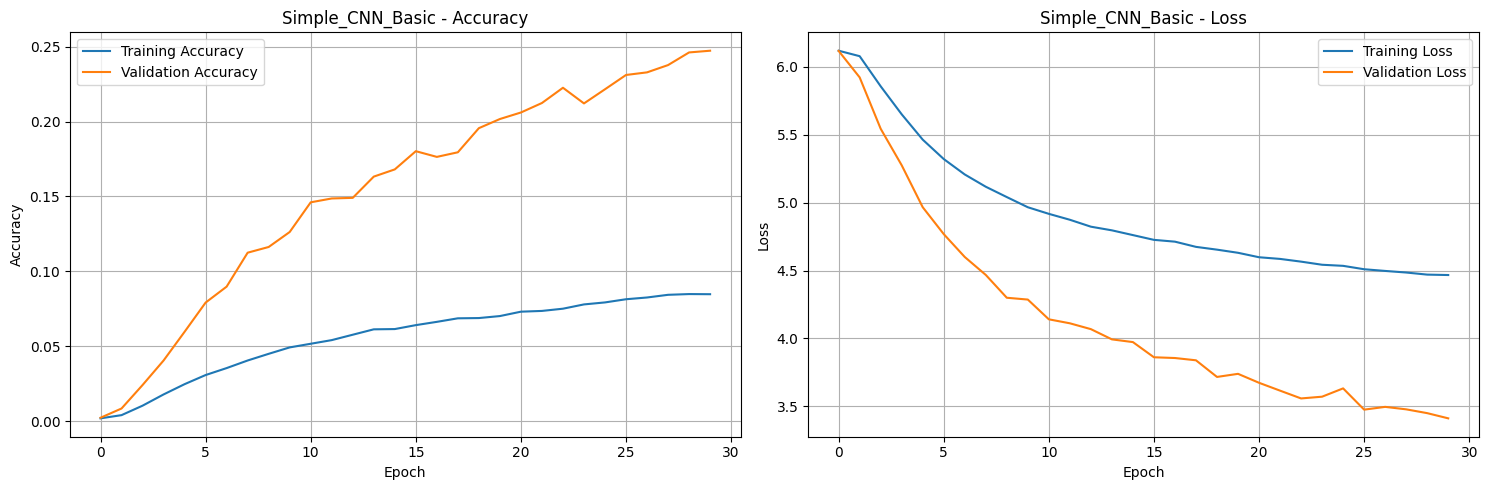


🎯 Training: Medium_CNN_Basic
----------------------------------------


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-307639580.py:25: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, alpha=1, sigma=50, alpha_affine=50),  # Replaced IAAPiecewiseAffine
/tmp/ipython-input-307639580.py:34: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training samples: 87146
Validation samples: 21787
Input shape: (64, 64, 3)
Epoch 1/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.0046 - loss: 6.2235
Epoch 1: val_accuracy improved from -inf to 0.02442, saving model to best_Medium_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 953s 696ms/step - accuracy: 0.0046 - loss: 6.2233 - val_accuracy: 0.0244 - val_loss: 5.3817 - learning_rate: 0.0010
Epoch 2/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.0255 - loss: 5.2877
Epoch 2: val_accuracy improved from 0.02442 to 0.09338, saving model to best_Medium_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 954s 701ms/step - accuracy: 0.0255 - loss: 5.2876 - val_accuracy: 0.0934 - val_loss: 4.2879 - learning_rate: 0.0010
Epoch 3/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.0672 - loss: 4.5368
Epoch 3: val_accuracy improved from 0.09338 to 0.13320, saving model to best_Medium_CNN_Basic.h5


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 982s 721ms/step - accuracy: 0.0672 - loss: 4.5367 - val_accuracy: 0.1332 - val_loss: 3.7894 - learning_rate: 0.0010
Epoch 4/30
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.1146 - loss: 4.0255

In [ ]:
# Initialize trainer
print(f"Initializing trainer with {len(image_paths)} images and {len(classes)} classes...")
trainer = ModelTrainer(image_paths, labels, classes)

# Start training (we'll use a smaller number of epochs for initial testing)
# For full training, use epochs=50 or more
results = trainer.train_model_comparison(epochs=30, batch_size=64)

# Compare results
comparison_df = trainer.compare_results()

print("\n🎯 TRAINING COMPLETED!")
print("Next steps:")
print("1. Analyze the results to select the best model")
print("2. Perform hyperparameter tuning on the best model")
print("3. Evaluate on test set with detailed metrics")
print("4. Implement the web interface for real-time prediction")